<a href="https://colab.research.google.com/github/ameykasbe/CS540_app_review/blob/master/SocialNetworking_playStore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
pd.set_option('display.max_rows', None)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv("/content/drive/MyDrive/CS540/social_network_play_store.csv")

In [24]:
df = df[['appName', 'source', 'review_date','review_description','rating']]

In [25]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
def preprocess_text(text):
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove alphanumeric characters
    text = re.sub(r'\w*\d\w*', '', text).strip()
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Join the filtered tokens back into a string
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [27]:
# Apply the preprocessing function to the dataframe columns
df['preprocessed_reviews'] = df['review_description'].apply(preprocess_text)

In [28]:
average_rating = df.groupby('appName')['rating'].mean()
average_rating.sort_values(ascending = False)

appName
OK                                                   4.400
Likee - Let You Shine                                3.735
Medium                                               3.690
Houseparty                                           2.860
TikTok                                               2.830
Pinterest                                            2.700
Quora                                                2.660
Telegram                                             2.610
Signal Private Messenger                             2.590
Google Duo - High Quality Video Calls                2.500
LinkedIn                                             2.385
Discord                                              2.360
Viber Messenger                                      2.280
WhatsApp Messenger                                   2.225
KakaoTalk: Free Calls & Text                         2.225
Tumblr                                               2.200
Skype - free IM & video calls                   

In [29]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon') # Download the VADER lexicon
sia = SentimentIntensityAnalyzer() # Initialize the sentiment analyzer


sentiment_scores = []
for review in df['preprocessed_reviews']:
    scores = sia.polarity_scores(review)
    compound_score = scores['compound']
    if compound_score > 0:
        sentiment = "Positive"
    elif compound_score < 0:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    sentiment_scores.append(sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
df['sentiment_scores'] = sentiment_scores

In [32]:
ok_df = df[df['appName'] == 'OK']

In [33]:
ok_df.columns

Index(['appName', 'source', 'review_date', 'review_description', 'rating',
       'preprocessed_reviews', 'sentiment_scores'],
      dtype='object')

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer to convert text data into a bag of words representation
vectorizer = CountVectorizer(max_features= None, max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the preprocessed_reviews to a bag of words
bow = vectorizer.fit_transform(ok_df['preprocessed_reviews'])

# Initialize the LDA model
lda = LatentDirichletAllocation(n_components=20, random_state=0)

# Fit the LDA model on the bag of words data
lda.fit(bow)

temp = []
# Print the top 10 words for each of the 10 topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    tempTopic = " ".join([feature_names[i]
                    for i in topic.argsort()[:-29:-1]])
    temp.append(tempTopic)

In [35]:
data = {'Topic': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'],
        'Text': [temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7], temp[8], temp[9],
                 temp[10], temp[11], temp[12], temp[13], temp[14], temp[15], temp[16], temp[17], temp[18], temp[19]]}


ok_topics = pd.DataFrame(data)

In [36]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_keywords(text):
    doc = nlp(text)
    keywords = [token.text for token in doc if not token.is_stop and token.is_alpha and len(token)>2][:10]
    return keywords

In [ ]:
df['keywords'] = df['preprocessed_reviews'].apply(lambda x: extract_keywords(x))

In [37]:
ok_topics['keywords'] = ok_topics['Text'].apply(lambda x: extract_keywords(x))

In [40]:
ok_topics.shape

(20, 3)

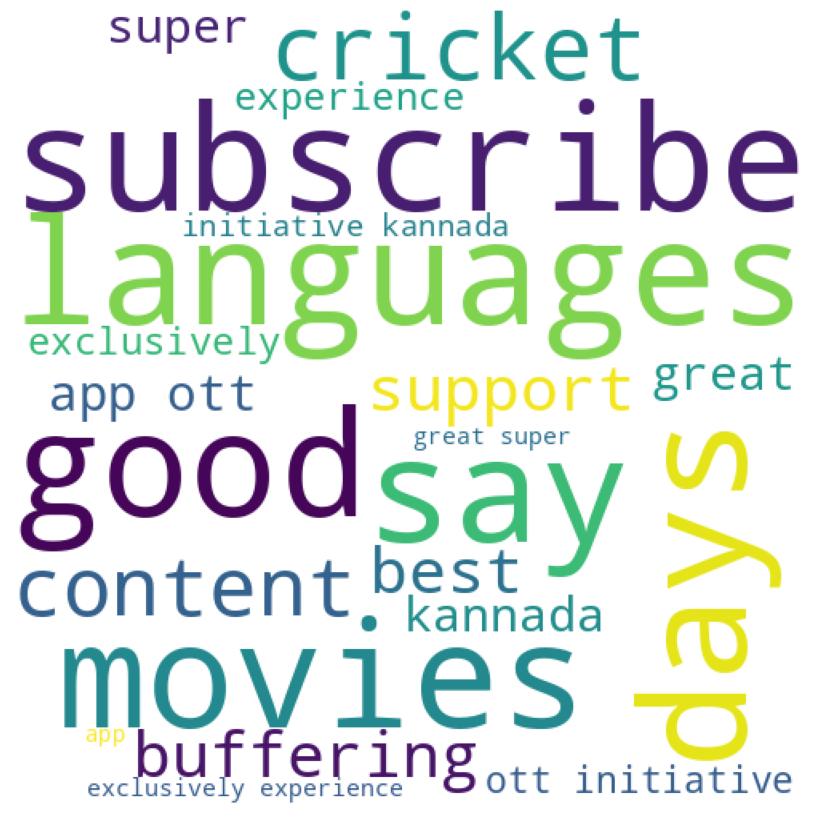

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# combine text from all rows of the column into one string
text = " ".join(review for review in ok_topics['Text'])

# Assuming 'text' is a string containing all the text data
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(text) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [42]:
pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.7 MB/s eta 0:00:00


In [43]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [44]:
data = list(ok_df['preprocessed_reviews'])
sentiments = sentiment_pipeline(data)

sentiments_labels = [item['label'] for item in sentiments]

In [45]:
ok_df['sentiments'] = sentiments_labels

<ipython-input-45-2172afbee334>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ok_df['sentiments'] = sentiments_labels


In [46]:
ok_df['sentiment_scores'].value_counts()

Positive    16
Neutral      7
Negative     2
Name: sentiment_scores, dtype: int64

In [47]:
ok_df['sentiments'].value_counts()

POSITIVE    17
NEGATIVE     8
Name: sentiments, dtype: int64

In [ ]:
average_rating = ok_df.groupby('sentiment_scores')['rating'].mean()
average_rating.sort_values(ascending = False)

In [49]:
average_rating = ok_df.groupby('sentiments')['rating'].mean()
average_rating.sort_values(ascending = False)

sentiments
POSITIVE    5.000
NEGATIVE    3.125
Name: rating, dtype: float64

In [51]:
duo_df= df[df['appName'] == 'Google Duo - High Quality Video Calls']

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer to convert text data into a bag of words representation
vectorizer = CountVectorizer(max_features= None, max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the preprocessed_reviews to a bag of words
bow = vectorizer.fit_transform(duo_df['preprocessed_reviews'])

# Initialize the LDA model
lda = LatentDirichletAllocation(n_components=20, random_state=0)

# Fit the LDA model on the bag of words data
lda.fit(bow)

temp = []
# Print the top 10 words for each of the 10 topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    tempTopic = " ".join([feature_names[i]
                    for i in topic.argsort()[:-29:-1]])
    temp.append(tempTopic)

In [54]:
data = {'Topic': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'],
        'Text': [temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7], temp[8], temp[9],
                 temp[10], temp[11], temp[12], temp[13], temp[14], temp[15], temp[16], temp[17], temp[18], temp[19]]}


duo_topics = pd.DataFrame(data)

In [55]:
duo_topics['keywords'] = duo_topics['Text'].apply(lambda x: extract_keywords(x))

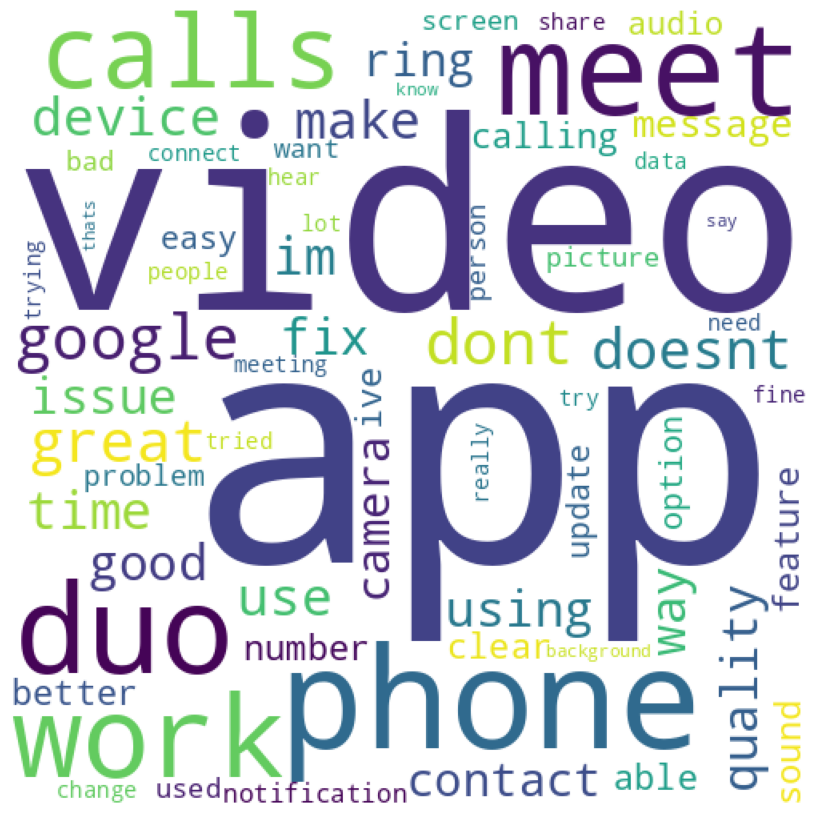

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# combine text from all rows of the column into one string
text = " ".join(review for review in duo_topics['Text'])

# Assuming 'text' is a string containing all the text data
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(text) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [57]:
data = list(duo_df['preprocessed_reviews'])
sentiments = sentiment_pipeline(data)

sentiments_labels = [item['label'] for item in sentiments]

In [58]:
duo_df['sentiments'] = sentiments_labels

<ipython-input-58-d9850a0df9b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duo_df['sentiments'] = sentiments_labels


In [59]:
duo_df['sentiment_scores'].value_counts()

Positive    135
Negative     63
Neutral       2
Name: sentiment_scores, dtype: int64

In [60]:
duo_df['sentiments'].value_counts()


NEGATIVE    168
POSITIVE     32
Name: sentiments, dtype: int64

In [61]:
average_rating = duo_df.groupby('sentiment_scores')['rating'].mean()
average_rating.sort_values(ascending = False)

sentiment_scores
Positive    2.97037
Negative    1.52381
Neutral     1.50000
Name: rating, dtype: float64

In [62]:
average_rating = duo_df.groupby('sentiments')['rating'].mean()
average_rating.sort_values(ascending = False)

sentiments
POSITIVE    4.218750
NEGATIVE    2.172619
Name: rating, dtype: float64